<a href="https://colab.research.google.com/github/koromeng/MLTSA22_KOromeng/blob/main/HW1/HW1_KOromeng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 1- Fitting a line to GRB afterglow photometry

Using different methods to fit the simplet model to data -a line. We will explore different method.

In [78]:
##Initial imports - Pandas, numpy and pylab
import pandas as pd
import pylab as pl
import numpy as np
%pylab inline

##A stylesheet to design/define plot viz parameters from Dr. Bianco 
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/master/fbb.mplstyle")
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#Reading and preparing input dataset

In [79]:
#Read the dataset, we use pandas for this
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/"+
                    "MLTSA22_FBianco/main/HW1/grb050525A.csv")
grbAG.head() #spits out the first 5 entries

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


In [80]:
##Creating the log-time variable
grbAG["logtime"]=np.log10(grbAG.time)
grbAG.head() #view to check if a new variable logtime has been added

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


###Data Visualisation

In [82]:
#retrieving all magnitudes for a filter, dump it into a different frame??
grbAG1=grbAG.loc[grbAG["filter"] == f, "mag"]
grbAG1.head()

Series([], Name: mag, dtype: float64)

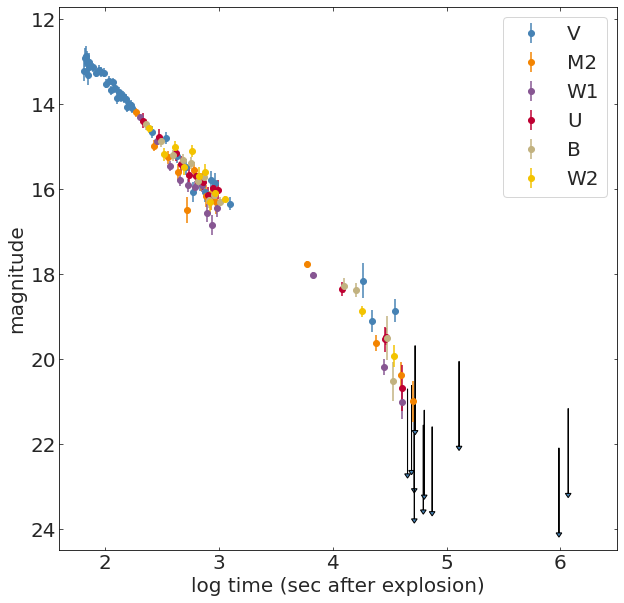

In [83]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)
    
#loop on every filter to plot - this will give differnt colors naturally. 
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
         pl.errorbar(x=grbAG.loc[grbAG["filter"] == f, "logtime"],
                     y=grbAG.loc[grbAG["filter"] == f, "mag"],
                    yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], 
                     fmt="o")
    
# plot the upperlimits as arrows 
for i in grbAG[grbAG.upperlimit == 1].index:
         pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24.5,11.7) 
pl.xlim(1.6, 6.5)         
pl.legend(grbAG["filter"].unique())

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);

*Figure* 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

#Data cleaning
Remove upper limits or censored data

In [84]:
grbAG=grbAG.loc[grbAG.upperlimit == 0] #Retains the entries with lower limits and removes upper limits

#Fitting models to data 
- Model 1-Normal Equation (slope and intercept)
- Model 2- sklearn linear regression
- Model 3 and 4- minimizing an objective objective fx(i.L1 metric and then ii.chi-square)

In [85]:
x = grbAG['logtime'] # logtime is the exogenous variable?

X = np.c_[np.ones((len(grbAG), 1)), #changes shape of the logtime variable
          x]

y = grbAG['mag']

print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


### 1. Normal Equation

In [86]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
                                           
print ("best fit parameters from the Normal Equation: " + 
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


### 2. Fitting a line to the data with sklearn LinearRegression

In [87]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from sklearn.linear_model import LinearRegression

#sklearn is an object oriented package. You will call the function which will create a model
lr=LinearRegression()
lr.fit(X,y) #fitting the model

print ("best fit parameters from the sklearn LinearRegression(): " + 
       "intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[1])) #this will spit out intercept and coefficients

best fit parameters from the sklearn LinearRegression(): intercept 8.58, slope 2.51


### 3. Minimizing an objective function

#### a.) L1 metric

In [88]:
# Choose the L1 metric to use as an objective function

#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def line(x, intercept, slope):
    return (x*slope + intercept)

def l1(args, x, y):
    a, b = args
    differences = y - line(x,b,a)
    return  sum(abs(differences)) #see slides!

#this can be important, a bad choice can get us stuck in a local minimum. But for this simple problem we can just guess whaetever
initialGuess = (10, 1) 

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("") #prints out space between L1 solution and slope, intercept
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

      fun: 26.304340597340804
 hess_inv: array([[ 0.00759366, -0.01591281],
       [-0.01591281,  0.03413314]])
      jac: array([-1.95810866,  0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 271
      nit: 11
     njev: 66
   status: 2
  success: False
        x: array([2.64023314, 8.22681691])

best fit parameters from the minimization of L1: slope 2.64, intercept 8.23


#### a.) Pearson's chi squared

In [89]:
def chi2(args, x, y, s):
    a, b = args
    return sum((y-line(x,b,a))**2/s**2) #see notes

s =grbAG.magerr.values # assign the uncertainties to s. Its the column names "magerr"

initialGuess = (10, 1)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))

print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

      fun: 317.4206698013087
 hess_inv: array([[ 0.00020171, -0.00054289],
       [-0.00054289,  0.00155851]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([2.48019101, 8.59948748])

best fit parameters from the minimization of the chi squared: slope 2.48, intercept 8.60


#Deliverable -Plot all solutions/models with a legend
To do this best, you can create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.Include figure caption

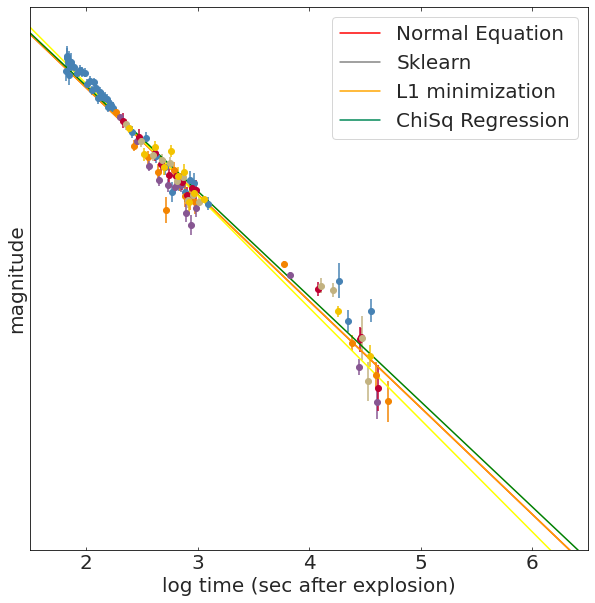

In [91]:
def plotline(intercept, slope, color, linestyle):
  x_output= np.linspace(start=1.5,stop=6.5,num=10)
  y_output= line(x_output, intercept, slope)
  ax.plot(x_output, y_output, color, linestyle)

ax = pl.figure(figsize=(10,10)).add_subplot(111)

# plot the datapoints as above as errorbars
# plot the upperlimits as arrows (see above)

#plot the models
for f in grbAG["filter"].unique():
  pl.errorbar(x=grbAG.loc[grbAG["filter"] == f, "logtime"],
              y=grbAG.loc[grbAG["filter"] == f, "mag"],
              yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], 
              fmt='o')
pl.ylim(24,11.7)          
pl.legend(grbAG["filter"].unique())

##PLOT THE MODELS
#normal equation
plotline(theta_best[0], theta_best[1], 'red', 'solid')      
#sklearn
plotline(lr.intercept_, lr.coef_[1], 'orange', 'dashed')      
#minimize L1
plotline(l1Solution.x[1],l1Solution.x[0], 'yellow','dotted') 
#minimize chi2
plotline(chi2Solution.x[1], chi2Solution.x[0], 'green','dashdot')
        
ax.legend(labels = ("Normal Equation", "Sklearn",'L1 minimization', 'ChiSq Regression'))

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);

*Figure 2*: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.